<a href="https://colab.research.google.com/github/atvrai/Log-Reg-Surv/blob/main/DEC_2025_ML_REVISION_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [199]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

In [200]:
dataset = load_breast_cancer() #It is a sklearn Bunch object (basically a dictionary-like container)

x = dataset.data # numpy array shape (n_samples, n_features)
y = dataset.target # numpy array shape (n_samples,)  (0/1)

df = pd.DataFrame(x , columns = dataset.feature_names)
df['target'] = y

In [201]:
df.head() #dataset visaulisation

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


Sample Info Check been done:-

In [202]:
print("X Shape:",x.shape)
print("Y Shape:",y.shape)
print("Feature names:", list(dataset.feature_names[:]), "...")  #preview

# class balance
unique, counts = np.unique(y, return_counts=True)  #
print("Class distribution:", dict(zip(unique, counts)))  #dictionary library of python


print("Any NaNs in x:", np.isnan(x).any()) # any missing value in X which are unlabelled
print("Any NaNs in y:", np.isnan(y).any()) # any missing values in Y which are unlabelled

X Shape: (569, 30)
Y Shape: (569,)
Feature names: [np.str_('mean radius'), np.str_('mean texture'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean smoothness'), np.str_('mean compactness'), np.str_('mean concavity'), np.str_('mean concave points'), np.str_('mean symmetry'), np.str_('mean fractal dimension'), np.str_('radius error'), np.str_('texture error'), np.str_('perimeter error'), np.str_('area error'), np.str_('smoothness error'), np.str_('compactness error'), np.str_('concavity error'), np.str_('concave points error'), np.str_('symmetry error'), np.str_('fractal dimension error'), np.str_('worst radius'), np.str_('worst texture'), np.str_('worst perimeter'), np.str_('worst area'), np.str_('worst smoothness'), np.str_('worst compactness'), np.str_('worst concavity'), np.str_('worst concave points'), np.str_('worst symmetry'), np.str_('worst fractal dimension')] ...
Class distribution: {np.int64(0): np.int64(212), np.int64(1): np.int64(357)}
Any NaNs in x: False
An

In [203]:
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size =  0.2 , random_state = 42 , stratify = y)
#Result: Every time you run the code with random_state=42, you will get the exact same division of data. If you didn't set this, running the code multiple times would result in slightly different splits each time, making it difficult to compare model results reliably.
#stratify ensures that har class me saare data's equally divide ho

print("Train Shape" , x_train.shape , "Test Shape ", x_test.shape)

Train Shape (455, 30) Test Shape  (114, 30)


Sigmoid Loss Function:-
S(x) = 1/(1+e^-x)

Binary Cross Enotropy Formula:-
L(y,y') = yi*log(yi') - (1-yi)*log(1-yi')
BCE = -1/N*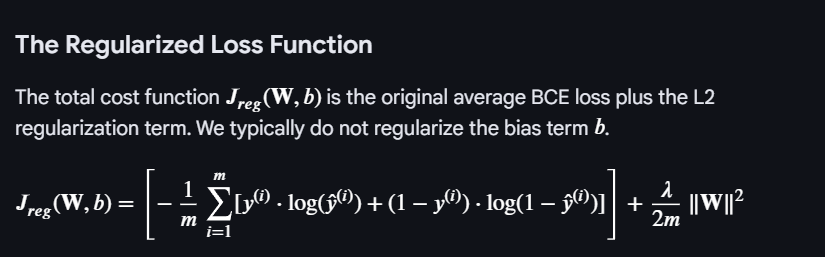SUM(L(yi , yi'))

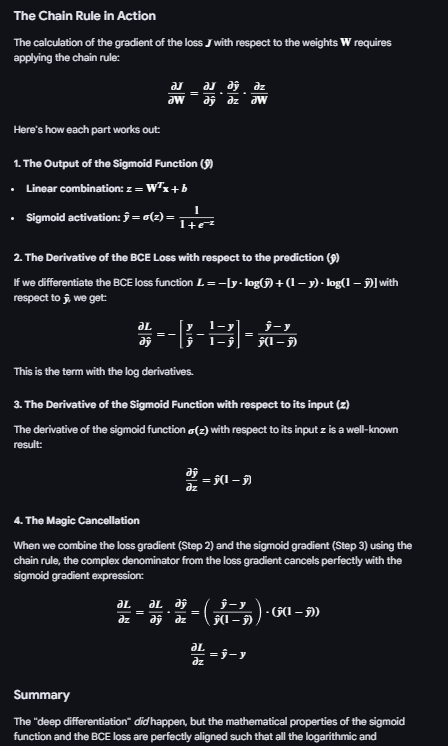

In [204]:
def ssigmoid(z):
    z = np.asarray(z, dtype=np.float64)
    out = np.empty_like(z, dtype=np.float64)
    pos_mask = z >= 0
    neg_mask = ~pos_mask
    # for positive z: 1 / (1 + exp(-z)) -- safe because -z <= 0
    out[pos_mask] = 1.0 / (1.0 + np.exp(-z[pos_mask]))
    # for negative z: exp(z) / (1 + exp(z)) -- safe because z <= 0
    exp_z = np.exp(z[neg_mask])
    out[neg_mask] = exp_z / (1.0 + exp_z)
    return out

# #sigmoid normal way to be done
# def sigmoid(z):
#     return 1 / (1 + np.exp(-z))


# -------------------------
# 2) Binary Cross-Entropy Loss (with optional L2 reg)
# -------------------------
def bce_loss(y_true , y_pred , weights = None , l2_lambda = 0.0):
  """
    y_true: (n,) with values 0/1
    y_pred_proba: (n,) probabilities in [0,1] -->this is y_pred over here...
    weights: (d,) weight vector (exclude bias) for L2 regularization
    l2_lambda: scalar regularization strength
    """
  y = np.asarray(y_true, dtype=np.float64)
  p = np.asarray(y_pred, dtype=np.float64)

  eps = 1e-12
  p = np.clip(p, eps, 1 - eps) #clipping min val of prob to 1e-12
  loss = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
  if(weights is not None) and (l2_lambda > 0.0):
    loss += (l2_lambda / (2*len(y))) * np.sum(weights**2) #L2 regularization added to the loss fucntion...

  return loss


# -------------------------
# 3) Gradients for logistic regression
# -------------------------
def compute_gradients(x, y, w, b, l2_lambda=0.0):
    """
    x: (n, d)
    y: (n,)
    w: (d,)
    b: scalar
    returns: grad_w (d,), grad_b (scalar)
    we know z = Wx + b --->y_pred = sigmoid(z)
    """
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    w = np.asarray(w, dtype=np.float64)
    n = x.shape[0] #what is n no of colums in dataset i.e no of elements in the array w
    z = x.dot(w) + b #dot product
    p = ssigmoid(z) #prediceted to prob via sigmoid
    error = p - y                          # (n,)

    grad_w = (x.T.dot(error)) / n          # (d,) in the grad we have now xT . error which
    grad_b = np.mean(error)                # scalar
    if l2_lambda > 0.0:
        grad_w = grad_w + (l2_lambda / n) * w #regularization added to gradients as well we have taken the derivtive now we just making for upd vals
    return grad_w, float(grad_b)

# -------------------------
# 4) Fit: full-batch gradient descent with weight and biases updates happening in real time....
#all the computation and updates after the gradients are happeining over here....
# -------------------------
def fit(x, y, lr, n_iter, l2_lambda, verbose):
    """
    Trains logistic regression using full-batch GD.
    Returns: w (d,), b (scalar), loss_history list of (iter, loss)
    """
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    n, d = x.shape
        #n = number of samples / data points (rows)
        #d = number of features (columns)
    w = np.zeros(d, dtype=np.float64)
    b = 0.0
    loss_history = []
    # record initial loss
    p0 = ssigmoid(x.dot(w) + b) # dimensionally matching
    loss_history.append((0, bce_loss(y, p0, weights=w, l2_lambda=l2_lambda))) # 1st entry at 0 epochs

    for it in range(1, n_iter + 1):
        grad_w, grad_b = compute_gradients(x, y, w, b, l2_lambda=l2_lambda) #we calculating the grad for each iteration...
        w -= lr * grad_w #update of weights and biases for these...
        b -= lr * grad_b #we can add different types of optimizations to learning rates as well from here....
        if (it % 10 == 0) or (it == 1): #show the values after every 10 epochs and 1st one..
            p = ssigmoid(x.dot(w) + b) #z value calculated...
            loss = bce_loss(y, p, weights=w, l2_lambda=l2_lambda) #getting loss to store in history
            loss_history.append((it, loss))
            if verbose and (it % 100) == 0:
              print(f"Iter {it}/{n_iter} - Loss: {loss:.6f}") #printing only after 100 epochs

    return w, b, loss_history
    # for it in range(1 , n_iter+1):
    #   grad_w , grad_b = compute_gradients(x,y,w,b,l2_lambda=l2_lambda)
    #   w = w - lr*grad_w
    #   b = b - lr*grad_b

    #   if(it%10) or (it==1):
    #     p = ssigmoid(x.dot(w)+b)
    #     loss = bce_loss(y , p , weights = w , l2_lambda = l2_lambda)
    #     loss_history.append((it , loss))
    #     if (it%100==0):
    #       print(f"Iter{it}/{n_iter} - LOSS :{loss:.6f}")
    # return w, b, loss_history

In [205]:
def predict_prob(x, w, b):
    x = np.asarray(x, dtype=np.float64)
    w = np.asarray(w, dtype=np.float64)
    return ssigmoid(x.dot(w) + b) #after all the fine tuing we are prediction the values for each of the datset values...

def predict(x, w, b, threshold=0.5):
    prob = predict_prob(x, w, b)
    return (prob >= threshold).astype(int)


In [206]:
# --- SOLUTION: Add Data Scaling ---
scaler = StandardScaler()

# Fit scaler on training data and transform both train/test sets
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
# ----------------------------------

# Now use the scaled data for fitting
# w, b, loss_history = fit(x_train, y_train, lr=0.01, n_iter=5000, l2_lambda=0.01 , verbose=True)
w , b , loss_history = fit(x_train_scaled, y_train, lr=0.01, n_iter=5000, l2_lambda=0.01 , verbose=True)
# w , b , loss_history = fit(x_train, y_train, lr=0.01, n_iter=5000, l2_lambda=0.01 , verbose=True)

Iter 100/5000 - Loss: 0.244669
Iter 200/5000 - Loss: 0.182233
Iter 300/5000 - Loss: 0.153947
Iter 400/5000 - Loss: 0.137208
Iter 500/5000 - Loss: 0.125931
Iter 600/5000 - Loss: 0.117710
Iter 700/5000 - Loss: 0.111390
Iter 800/5000 - Loss: 0.106343
Iter 900/5000 - Loss: 0.102196
Iter 1000/5000 - Loss: 0.098712
Iter 1100/5000 - Loss: 0.095733
Iter 1200/5000 - Loss: 0.093150
Iter 1300/5000 - Loss: 0.090882
Iter 1400/5000 - Loss: 0.088871
Iter 1500/5000 - Loss: 0.087073
Iter 1600/5000 - Loss: 0.085453
Iter 1700/5000 - Loss: 0.083983
Iter 1800/5000 - Loss: 0.082642
Iter 1900/5000 - Loss: 0.081413
Iter 2000/5000 - Loss: 0.080280
Iter 2100/5000 - Loss: 0.079232
Iter 2200/5000 - Loss: 0.078260
Iter 2300/5000 - Loss: 0.077353
Iter 2400/5000 - Loss: 0.076506
Iter 2500/5000 - Loss: 0.075712
Iter 2600/5000 - Loss: 0.074966
Iter 2700/5000 - Loss: 0.074263
Iter 2800/5000 - Loss: 0.073599
Iter 2900/5000 - Loss: 0.072971
Iter 3000/5000 - Loss: 0.072375
Iter 3100/5000 - Loss: 0.071809
Iter 3200/5000 - 

In [207]:
y_test_prob = predict_prob(x_test_scaled, w, b)
y_test_pred = predict(x_test_scaled, w, b)

In [208]:
#Implement Accuracy Parameters....
def accuracy(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(y_true == y_pred)) #remember float or it will be done in int maybe...

def precision(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    tp = np.sum((y_pred == 1) & (y_true == 1)) #predicted what was expected
    fp = np.sum((y_pred == 1) & (y_true == 0)) #others who predicted this output
    if tp + fp == 0:
        return 0.0
    return float(tp) / (tp + fp)

def recall(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    tp = np.sum((y_pred == 1) & (y_true == 1)) #predicted what was expected
    fn = np.sum((y_pred == 0) & (y_true == 1)) #this did not predict what was expected
    if tp + fn == 0:
        return 0.0
    return float(tp) / (tp + fn)

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    if p + r == 0:
        return 0.0
    return 2.0 * p * r / (p + r)



def roc_auc_by_hand(y_true, y_scores):
    """
    Compute ROC AUC by enumerating thresholds at unique score values.
    Returns: (auc, fpr_array, tpr_array, thresholds_array)

    Notes:
      - If y_true contains only one class, AUC is undefined; function returns np.nan for auc.
      - thresholds returned are the thresholds used (sorted by resulting FPR order).
    """

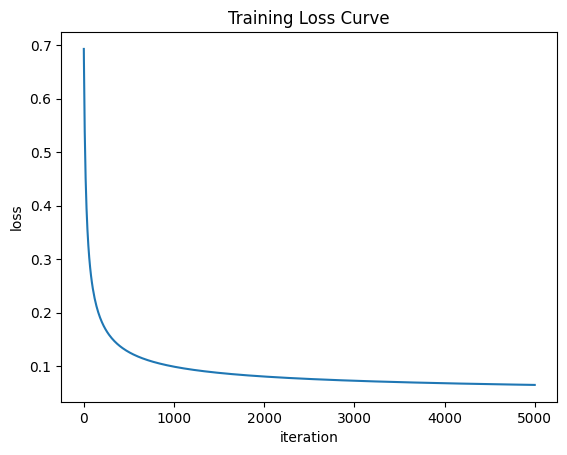

In [209]:
#PLOT
its = [it for it,loss in loss_history]
losses = [loss for it,loss in loss_history]
plt.plot(its, losses)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Training Loss Curve")
plt.show()

In [210]:
print("Accuracy:", accuracy(y_test, y_test_pred))
print("Precision:", precision(y_test, y_test_pred))
print("Recall:", recall(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))

# auc_hand, fpr, tpr, thr = roc_auc_by_hand(y_test, y_test_proba)
# print("AUC (hand):", auc_hand)

Accuracy: 0.9736842105263158
Precision: 0.9859154929577465
Recall: 0.9722222222222222
F1: 0.979020979020979


In [211]:
from sklearn.metrics import log_loss

# diagnostic fit that prints detailed stats
def fit_diagnostic(X, y, lr=0.1, n_iter=500, l2_lambda=0.0, print_every=50):
    X = np.asarray(X, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    n, d = X.shape
    w = np.zeros(d, dtype=np.float64)
    b = 0.0
    loss_history = []

    def ssigmoid(z):
        z = np.asarray(z, dtype=np.float64)
        return np.where(z >= 0, 1.0 / (1.0 + np.exp(-z)), np.exp(z) / (1.0 + np.exp(z)))

    for it in range(1, n_iter+1):
        z = X.dot(w) + b
        p = ssigmoid(z)                  # stable everywhere
        # numeric-safety
        p = np.clip(p, 1e-12, 1 - 1e-12)

        # loss components
        bce = -np.mean(y*np.log(p) + (1-y)*np.log(1-p))
        reg = (l2_lambda / (2.0 * n)) * np.sum(w**2) if l2_lambda>0 else 0.0
        loss = bce + reg

        # grads
        error = p - y
        grad_w = (X.T.dot(error)) / n
        grad_b = np.mean(error)
        if l2_lambda > 0:
            grad_w += (l2_lambda / n) * w

        # diagnostics print
        if it % print_every == 0 or it == 1:
            print(f"Iter {it}: loss={loss:.6f}, bce={bce:.6f}, reg={reg:.6f}")
            print(f"         z_min={z.min():.3e}, z_max={z.max():.3e}, p_min={p.min():.3e}, p_max={p.max():.3e}")
            print(f"         grad_w_norm={np.linalg.norm(grad_w):.3e}, grad_b={grad_b:.3e}, w_norm={np.linalg.norm(w):.3e}")
        # update
        w -= lr * grad_w
        b -= lr * grad_b
        loss_history.append((it, loss))

    return w, b, loss_history

# Run diagnostic on a short run to inspect behaviour
w_d, b_d, hist_d = fit_diagnostic(x_train, y_train, lr=0.1, n_iter=300, l2_lambda=0.1, print_every=30)


Iter 1: loss=0.693147, bce=0.693147, reg=0.000000
         z_min=0.000e+00, z_max=0.000e+00, p_min=5.000e-01, p_max=5.000e-01
         grad_w_norm=9.516e+01, grad_b=-1.264e-01, w_norm=0.000e+00
Iter 30: loss=17.898403, bce=17.307343, reg=0.591061
         z_min=-1.382e+05, z_max=-3.296e+03, p_min=1.000e-12, p_max=1.000e-12
         grad_w_norm=4.572e+02, grad_b=-6.264e-01, w_norm=7.334e+01
Iter 60: loss=19.343810, bce=17.307343, reg=2.036467
         z_min=-2.567e+05, z_max=-6.126e+03, p_min=1.000e-12, p_max=1.000e-12
         grad_w_norm=4.572e+02, grad_b=-6.264e-01, w_norm=1.361e+02
Iter 90: loss=20.974533, bce=17.186381, reg=3.788152
         z_min=-2.573e+05, z_max=6.015e+01, p_min=1.000e-12, p_max=1.000e+00
         grad_w_norm=4.555e+02, grad_b=-6.224e-01, w_norm=1.857e+02
Iter 120: loss=23.143810, bce=17.003705, reg=6.140105
         z_min=-3.102e+05, z_max=2.285e+03, p_min=1.000e-12, p_max=1.000e+00
         grad_w_norm=4.527e+02, grad_b=-6.154e-01, w_norm=2.364e+02
Iter 150: l

/tmp/ipython-input-1372116400.py:14: RuntimeWarning: overflow encountered in exp
  return np.where(z >= 0, 1.0 / (1.0 + np.exp(-z)), np.exp(z) / (1.0 + np.exp(z)))
/tmp/ipython-input-1372116400.py:14: RuntimeWarning: invalid value encountered in divide
  return np.where(z >= 0, 1.0 / (1.0 + np.exp(-z)), np.exp(z) / (1.0 + np.exp(z)))


In [212]:
from sklearn.linear_model import LogisticRegression

In [213]:
# Train sklearn logistic regression (L2 by default). Increase max_iter to ensure convergence.
clf = LogisticRegression(solver='lbfgs', max_iter=1000, C=1.0)  # C = 1/lambda
clf.fit(x_train, y_train)

# Predictions & probabilities
y_test_prob = clf.predict_proba(x_test)[:, 1]   # probability for class 1
y_test_pred = clf.predict(x_test)

# Metrics
print("sklearn LogisticRegression results:")
print("  log_loss (BCE):", bce_loss(y_test, y_test_prob))  # this is the BCE on test
print("  Accuracy:", accuracy_score(y_test, y_test_pred))
print("  Precision:", precision_score(y_test, y_test_pred))
print("  Recall:", recall_score(y_test, y_test_pred))
print("  F1:", f1_score(y_test, y_test_pred))
# print("  ROC AUC:", roc_auc_score(y_test, y_test_proba))

sklearn LogisticRegression results:
  log_loss (BCE): 0.08727198407326321
  Accuracy: 0.9649122807017544
  Precision: 0.9722222222222222
  Recall: 0.9722222222222222
  F1: 0.9722222222222222


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [214]:
#log_loss (BCE): 0.08727198407326321 of SKLEARN
#mine Loss: 0.064584 which is better than that nice...

([<matplotlib.axis.YTick at 0x793e59e96810>,
 [Text(0, 0, 'Class 0'), Text(0, 1, 'Class 1')])

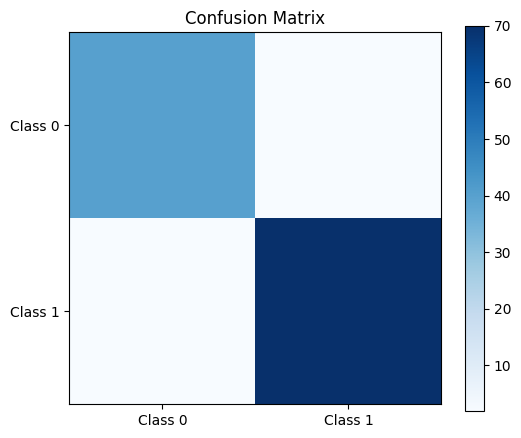

In [215]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()

classes = ['Class 0', 'Class 1']
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)


# **Addition Of Mini Batch to this code:-->**

In [223]:
def fit_minibatch(x , y , lr , n_epochs , batch_size , l2_lambda , verbose , shuffle=True):
  x = np.asarray(x , dtype = np.float64)
  y = np.asarray(y , dtype = np.float64)
  n , d = x.shape
  w = np.zeros(d , dtype = np.float64)
  b = 0.0
  loss_history2 = []

  for epoch in range(1 , n_epochs+1): # no of times whole datset is passed
    if shuffle:
      perm = np.random.permutation(n)
      xs = x[perm]
      ys = y[perm]
    else:
      xs, ys = x, y
    for i in range(0 , n , batch_size): #internal trianing in each epoch batch wise taking batches of 64 entries...
      xb = xs[i:i+batch_size]
      yb = ys[i:i+batch_size]
      grad_w, grad_b = compute_gradients(xb, yb, w, b, l2_lambda=l2_lambda)
      w -= lr*grad_w
      b -= lr*grad_b

    p = ssigmoid(x.dot(w) + b)
    loss = bce_loss(y, np.clip(p, 1e-12, 1-1e-12), weights=w, l2_lambda=l2_lambda)
    loss_history2.append((epoch, loss))
    if verbose and (epoch % 100 == 0):
      print(f"Epoch {epoch}/{n_epochs} - Loss: {loss:.6f}")
  return w , b , loss_history2

In [225]:
scaler = StandardScaler()

# Fit scaler on training data and transform both train/test sets
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

w , b , loss_history2 = fit_minibatch(x_train_scaled, y_train, lr=0.01, n_epochs=1000, batch_size = 64 , l2_lambda=0.01 , verbose=True , shuffle=True)

Epoch 100/1000 - Loss: 0.106325
Epoch 200/1000 - Loss: 0.085675
Epoch 300/1000 - Loss: 0.076748
Epoch 400/1000 - Loss: 0.071579
Epoch 500/1000 - Loss: 0.068036
Epoch 600/1000 - Loss: 0.065423
Epoch 700/1000 - Loss: 0.063365
Epoch 800/1000 - Loss: 0.061808
Epoch 900/1000 - Loss: 0.060448
Epoch 1000/1000 - Loss: 0.059304


In [226]:
y_test_prob_2 = predict_prob(x_test_scaled, w, b)
y_test_pred_2 = predict(x_test_scaled, w, b)

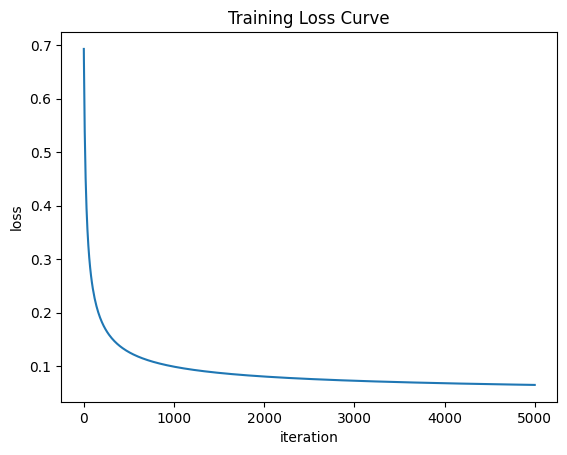

In [227]:
#PLOT
its = [it for it,loss in loss_history]
losses = [loss for it,loss in loss_history]
plt.plot(its, losses)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Training Loss Curve")
plt.show()

#**Addition of momntum to the learning rate..**

In [228]:
def fit_with_momentum(x, y, lr=0.01, n_iter=500, l2_lambda=0.0,beta=0.9, verbose=False, print_every=50):
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    n, d = x.shape
    w = np.zeros(d, dtype=np.float64)
    b = 0.0
    v_w = np.zeros_like(w)
    v_b = 0.0
    loss_history = []

    for it in range(1, n_iter+1):
        grad_w, grad_b = compute_gradients(x, y, w, b, l2_lambda=l2_lambda)

        # momentum update (classical momentum)
        v_w = beta * v_w + (1 - beta) * grad_w
        v_b = beta * v_b + (1 - beta) * grad_b

        w -= lr * v_w
        b -= lr * v_b

        if (it % print_every == 0) or (it == 1):
            p = ssigmoid(X.dot(w) + b)
            loss = bce_loss(y, np.clip(p, 1e-12, 1-1e-12), weights=w, l2_lambda=l2_lambda)
            loss_history.append((it, loss))
            if verbose:
                print(f"Iter {it}/{n_iter} - Loss: {loss:.6f} - ||v_w||={np.linalg.norm(v_w):.3e}")

    return w, b, loss_history
